Let's begin by loading our three main libraries: pandas, plotnine, and sqlite3:

In [0]:
import pandas as pd
import plotnine as p9
import sqlite3

Let's go ahead and mount the google drive to get easy-access to the course data:

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Let's create a database.

In [0]:
conn = sqlite3.connect('exercises.db')

Now populate the database with data from MIMIC and the Pima Indian diabetes dataset:

In [0]:
for filename, table in [
          ("mimic_iii/PATIENTS.csv", "patients"),
          ("mimic_iii/DIAGNOSES_ICD.csv", "diagnoses"),
          ("mimic_iii/D_ICD_DIAGNOSES.csv", "d_diagnoses"),
          ("diabetes.csv","diabetes")
]:
  data = pd.read_csv(f'/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/{filename}')
  data.to_sql(table, conn, if_exists='replace', index=False)

## Exercise 1
Do a SQL query using `pd.read_sql_query` to get all the gender information from the `patients` table and plot it in a bar chart:

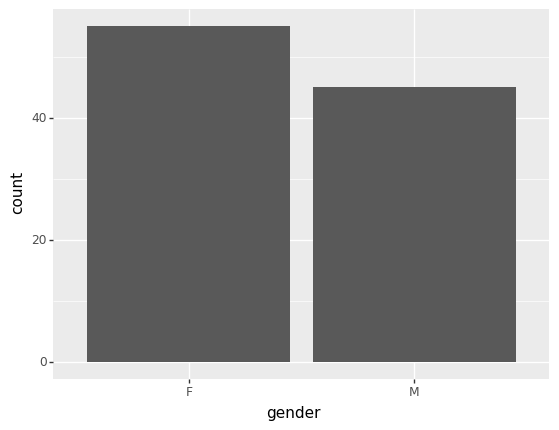

<ggplot: (8791079446988)>

In [0]:
p9.ggplot(pd.read_sql_query('SELECT gender FROM patients', conn), p9.aes(x='gender')) + p9.geom_bar()

If all went well, you should have reproduced a figure from Monday. Let's select `gender` and `icd9_code` information from the combination of the `patients` and `diagnoses` tables where their `subject_id`s coincides:

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, icd9_code
  FROM patients, diagnoses
  WHERE patients.subject_id == diagnoses.subject_id
''', conn)

Your data frame should have 1761 rows and 2 columns.

Now plot just the `icd9_code` information in a bar graph:

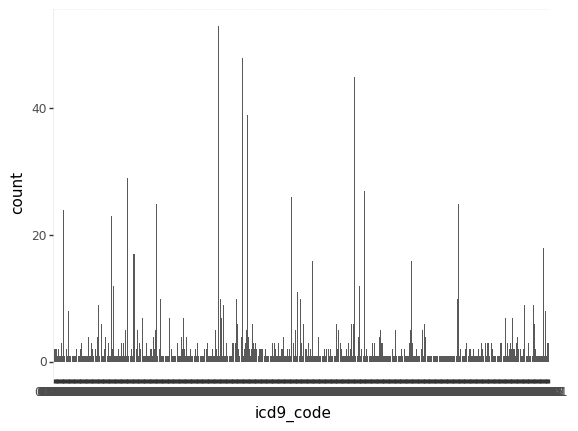

<ggplot: (8791078479245)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code')) + p9.geom_bar()

Whoa, that's way too many codes. Use `.value_counts()` to find out how many distinct `icd9_code` values there are.

In [0]:
diagnoses_by_gender['icd9_code'].value_counts()

4019     53
42731    48
5849     45
4280     39
51881    31
         ..
79094     1
51189     1
28984     1
78791     1
53082     1
Name: icd9_code, Length: 581, dtype: int64

Compare the `.value_counts()` to 10 and `sum` the result to find the number of diagnoses that appeared more than 10 times. Repeat for more than 20.

In [0]:
sum(diagnoses_by_gender['icd9_code'].value_counts() > 10)

28

In [0]:
sum(diagnoses_by_gender['icd9_code'].value_counts() > 20)

13

Add this additional condition to your `WHERE` clause with an `AND` to  extract the data only for diagnoses given more than 20 times:
```
icd9_code IN (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
  ```

This SELECT inside the parentheses is constructing a one column table listing only those icd9_codes that appear more than 20 times.

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, icd9_code
  FROM patients, diagnoses
  WHERE patients.subject_id == diagnoses.subject_id AND icd9_code IN (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
''', conn)

Using this smaller dataset, make a bar chart comparing the frequencies of various `icd9_code`s:

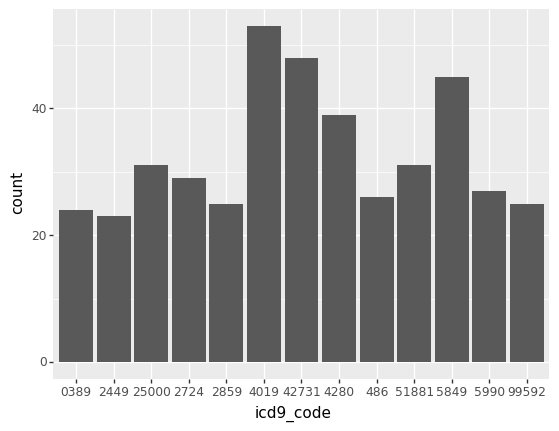

<ggplot: (-9223363245780904809)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code')) + p9.geom_bar()

Apply a `fill` aesthetic argument, based on the `gender`:



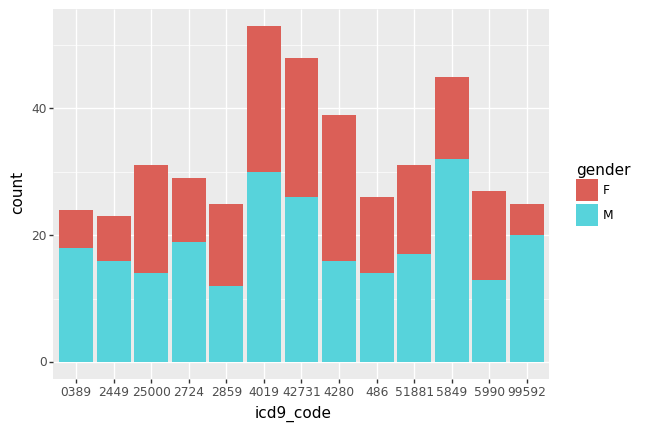

<ggplot: (8791074032367)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code', fill='gender')) + p9.geom_bar()

It's clear that `icd9_code` 99592 is assigned to males more than to females, but what about `icd9_code` 2859? It's hard to tell with stacked bar-charts. Recall that we can make the colors appear side-by-side using a `position='dodge'` parameter to `p9.geom_bar()`. Do that:

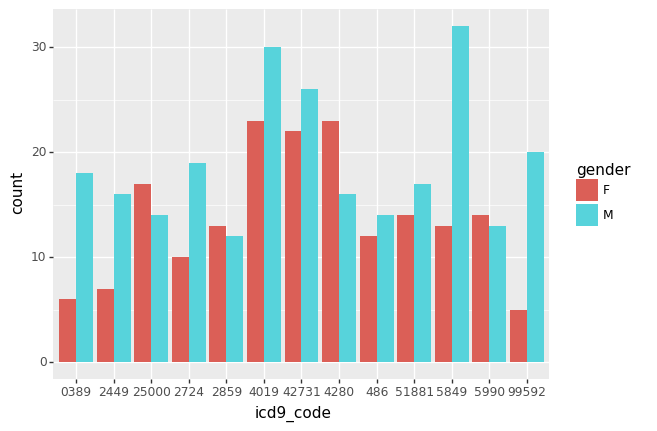

<ggplot: (-9223363245780900699)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='icd9_code', fill='gender')) + p9.geom_bar(position='dodge')

We now see clearly that more females got diagnosis code 2859 than males. What do these codes mean though? To find out, redo your SQL query again, this time also pulling in the `short_title` field from `d_diagnoses` where `d_diagnoses.icd9_code == diagnoses.icd9_code`.

In [0]:
diagnoses_by_gender = pd.read_sql_query('''
  SELECT gender, diagnoses.icd9_code, short_title
  FROM patients, diagnoses, d_diagnoses
  WHERE patients.subject_id == diagnoses.subject_id AND d_diagnoses.icd9_code == diagnoses.icd9_code and diagnoses.icd9_code in (
    SELECT icd9_code
    FROM diagnoses 
    GROUP BY icd9_code
    HAVING COUNT (icd9_code) > 20
  )
''', conn)

Check the query results to make sure that it looks like what you expect. Strictly speaking, you don't need to have `icd9_code` in your table, but I kept it in, giving me three columns and 426 rows.

In [0]:
diagnoses_by_gender

,gender,icd9_code,short_title
0,F,42731,Atrial fibrillation
1,F,4280,CHF NOS
2,F,25000,DMII wo cmp nt st uncntr
3,F,0389,Septicemia NOS
4,F,486,"Pneumonia, organism NOS"
...,...,...,...
421,M,2724,Hyperlipidemia NEC/NOS
422,F,486,"Pneumonia, organism NOS"
423,F,99592,Severe sepsis
424,F,2449,Hypothyroidism NOS


Now plot it, putting the `short_title` on the x-axis.

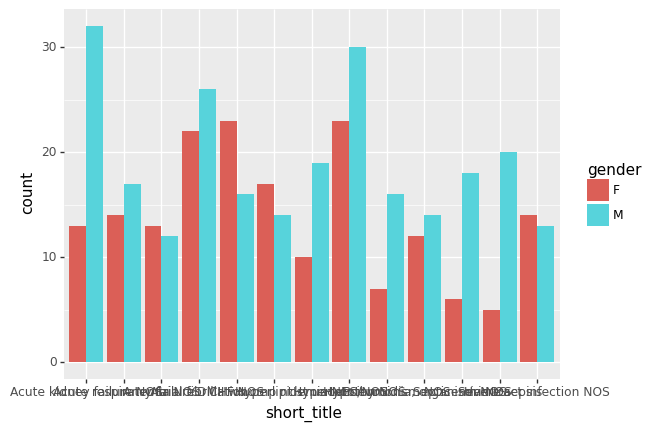

<ggplot: (8791073780088)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='short_title', fill='gender')) + p9.geom_bar(position='dodge')

Remember that adding `p9.theme(axis_text_x=p9.element_text(angle=90))` will rotate the x-axis labels by 90 degrees, making things easier to read. Do that:

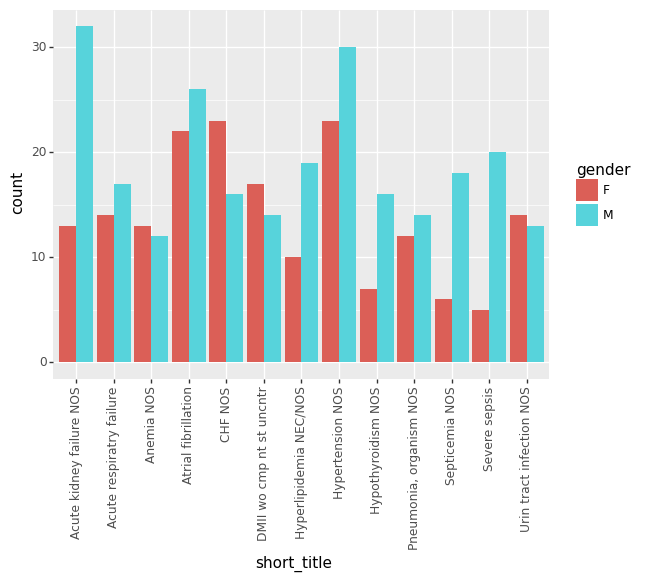

<ggplot: (-9223363245780925829)>

In [0]:
p9.ggplot(diagnoses_by_gender, p9.aes(x='short_title', fill='gender'))+ p9.geom_bar(position='dodge') + p9.theme(axis_text_x=p9.element_text(angle=90))

Visually, you can now quickly find the names of the four common diagnosis codes that are assigned to females more than to males.

## Exercise 2

Get solely the `pregnancy`, `Glucose`, `BMI` and `Outcome` from the `diabetes` table (each row representing a single observation of a patient).

In [0]:
diabetes_subset = pd.read_sql_query('''
SELECT Pregnancies, Glucose, BMI, Outcome from diabetes
''',conn)

`Pregnancies` is the number of pregnancies for each subject, we want to recode the value of a new variable, `Pregnancy` to be True if the patient has been pregnant, and False if not.
We also want to recode `Outcome` to replace with a descriptive variable ("diabetes" or "no diabetes").
We also want to alter the `Glucose` and `BMI` variables to set those at 0 to be NA, as they represent missingness rather than actual 0 values.

In [0]:
diabetes_subset['Pregnancy'] = diabetes_subset['Pregnancies']>0
diabetes_subset['Outcome'] = diabetes_subset['Outcome'].replace({0: "No Diabetes", 1: "Diabetes"})
diabetes_subset = diabetes_subset.replace({
    'Glucose': {0: float('nan')},
    'BMI': {0: float('nan')},
})

Look at your data frame to see if it looks the way you expect:

In [0]:
diabetes_subset

,Pregnancies,Glucose,BMI,Outcome,Pregnancy
0,6,148.0,33.6,Diabetes,True
1,1,85.0,26.6,No Diabetes,True
2,8,183.0,23.3,Diabetes,True
3,1,89.0,28.1,No Diabetes,True
4,0,137.0,43.1,Diabetes,False
...,...,...,...,...,...
763,10,101.0,32.9,No Diabetes,True
764,2,122.0,36.8,No Diabetes,True
765,5,121.0,26.2,No Diabetes,True
766,1,126.0,30.1,Diabetes,True


We don't need to, but go ahead and drop the `Pregnancies` column, then check to see if your dataframe changed the way you expected.

In [0]:
diabetes_subset = diabetes_subset.drop('Pregnancies', axis=1)
diabetes_subset

,Glucose,BMI,Outcome,Pregnancy
0,148.0,33.6,Diabetes,True
1,85.0,26.6,No Diabetes,True
2,183.0,23.3,Diabetes,True
3,89.0,28.1,No Diabetes,True
4,137.0,43.1,Diabetes,False
...,...,...,...,...
763,101.0,32.9,No Diabetes,True
764,122.0,36.8,No Diabetes,True
765,121.0,26.2,No Diabetes,True
766,126.0,30.1,Diabetes,True


Make box plots comparing the `Glucose` distribution  by `Diabetes`.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


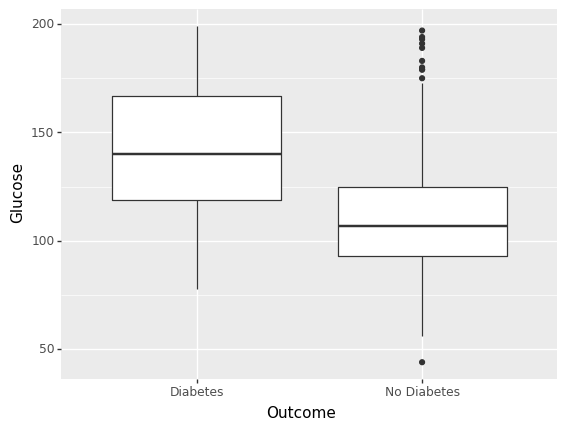

<ggplot: (8791073849899)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='Glucose', x='Outcome')) + p9.geom_boxplot()

**INTERPRET YOUR RESULTS**

Using `p9.facet_wrap`, facet this data by whether or not the patient has been pregnant with `Pregnancy`.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


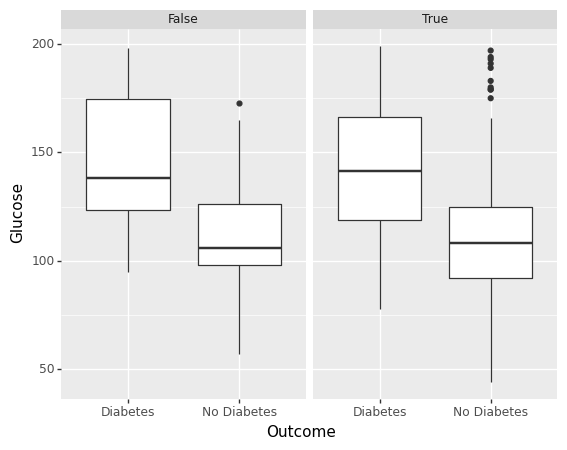

<ggplot: (-9223363245780631871)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='Glucose', x='Outcome')) + p9.geom_boxplot() + p9.facet_wrap('~Pregnancy')

**INTERPRET THIS GRAPH** How does prior preganancy  affect the likelihood a diabetic has high glucose? A non-diabetic? How does it affect the glucose value?

By specifying aesthetic maps for `x`, `y`, and `fill` create a box plot figure without faceting that compares the `BMI` for different `Outcome` and `Pregnancy` states.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


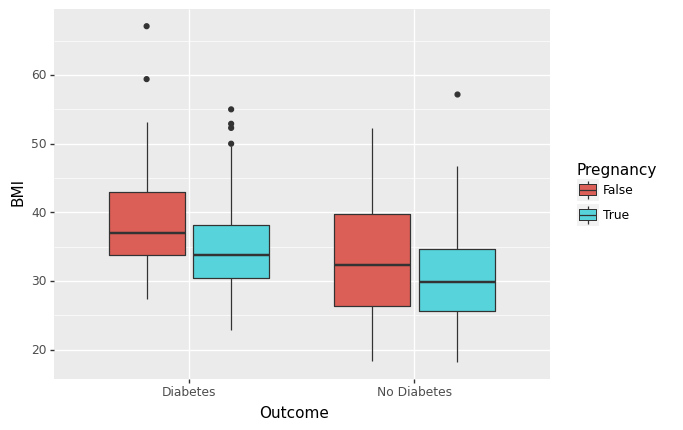

<ggplot: (8791071131852)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='BMI', x='Outcome', fill='Pregnancy')) + p9.geom_boxplot()

How does the median `BMI` compare between pregnant and non-pregnant women in each case? What happens if you switch `fill` and `x`? Does that make it easier or harder to answer this question?

Now, repeat the above, but make a violin plot instead.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_ydensity : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


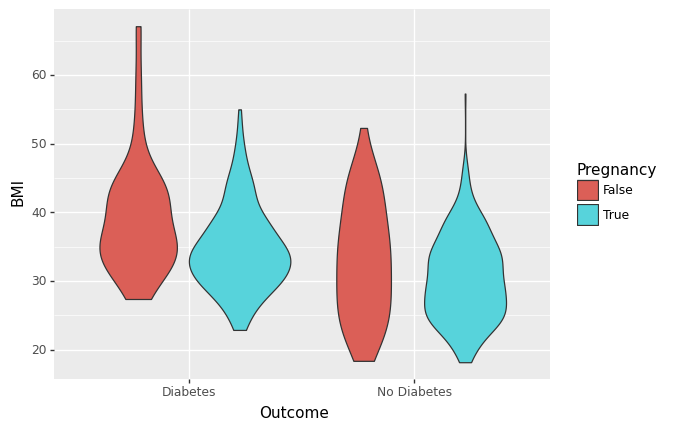

<ggplot: (8791071238734)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='BMI', x='Outcome', fill='Pregnancy')) + p9.geom_violin()

Compare the violin plot with the box plot. Can you find an advantage for each type of graph?

Plot `Glucose` vs `BMI` in a way that allows comparing the two `Outcome` cases. How do the values of `Glucose` for those with diabetes compare to those not having diabetes?

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 16 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


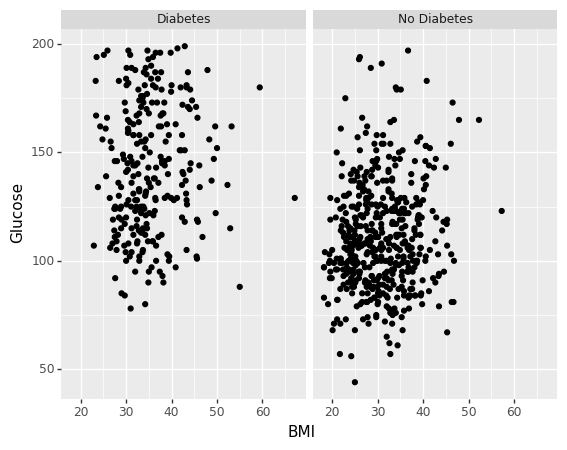

<ggplot: (-9223363245780951401)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='Glucose', x='BMI')) + p9.geom_point() + p9.facet_wrap('Outcome')

Use `p9.geom_smooth` to compare trend lines for how `Glucose` changes as `BMI` changes by `Outcome`. Is this a valid trendline?

/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 16 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


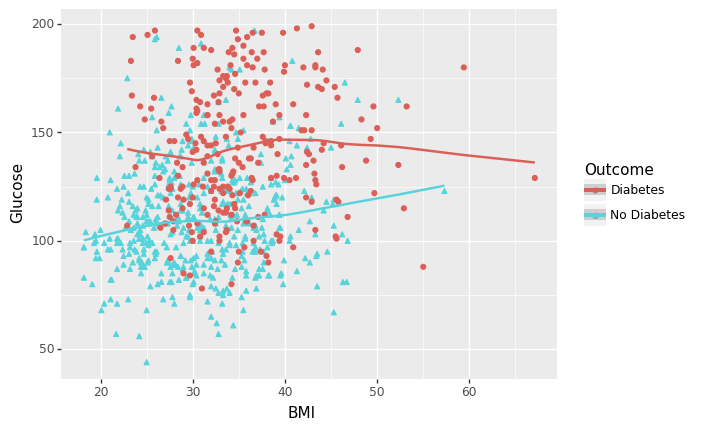

<ggplot: (-9223363245780563873)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='Glucose', x='BMI',color='Outcome',shape='Outcome')) + p9.geom_point() + p9.geom_smooth()

Do diabetics and non-diabetics show different body mass indices? Start by making a box-plot to compare them:

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


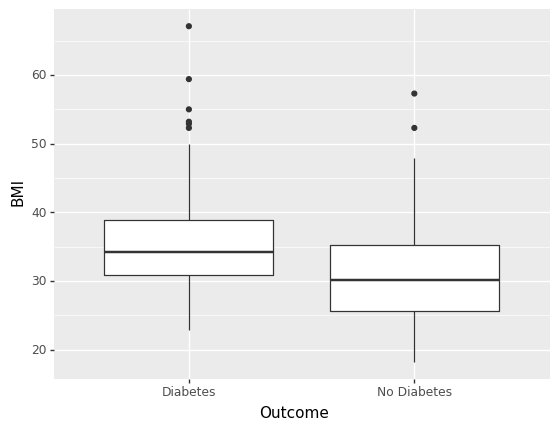

<ggplot: (-9223363245776303188)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='BMI', x='Outcome')) + p9.geom_boxplot()

Non-diabetics have an slightly lower median, but the ranges mostly overlap. We know what the subdivision looks like for pregnancy from our previous plot, with those women, with pregnancies having a slightly lower BMI irrespective of diabetic outcome.
When we swap our `fill` and `x`, we observe that the division between diabetics and non-diabetics is clearer within the pregnancy categories.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


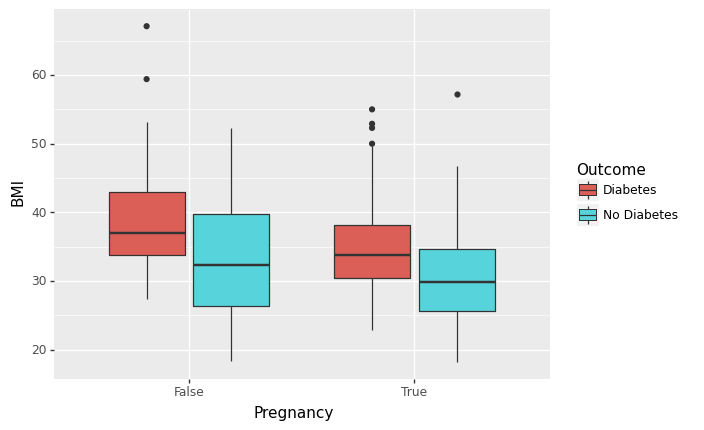

<ggplot: (8791071491781)>

In [0]:
p9.ggplot(diabetes_subset, p9.aes(y='BMI', fill='Outcome', x='Pregnancy')) + p9.geom_boxplot()